# Lung Cancer Data
We applied the SSVD algorithm on the lung cancer data. The data consists of 12625 expression levels of genes from 56 subjects, who are grouped by 4 cancer types. Our aim is to find "checkerboard" patterns in the data using biclustering. In other words, we try to find grouping of genes related to certain cancer types. 

The data.txt file is a 12625 $\times$ 56 matrix. Each row of corresponds to the individual subject, while each column corresponds to expression levels of genes.

Among the 56 subjects,

* row 1-20: pulmonary carcinoid samples (Carcinoid)
* row 21-33: colon cancer metastasis sampels (Colon)
* row 34-50: normal lung samples (Normal)
* row 51-56: small cell carcinoma samples (SmallCell)

In [1]:
import numpy as np
import math
from numba import jit
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time

In [4]:
def thresh(z,delta):
    return np.sign(z)*(np.abs(z) >= delta)*(np.abs(z)-delta)

def ssvd(X, gamu = 2, gamv = 2, merr = 10**(-4), niter = 100):
    # initial values
    U, s, V = np.linalg.svd(X)
    u0 = U.T[0]
    v0 = V.T[0]
    
    n = X.shape[0]
    d = X.shape[1]
    ud = 1
    vd = 1
    iters = 0
    SST = np.sum(X*X)
    while (ud > merr or vd > merr):
        iters = iters +1
        # Updating v
        z =  X.T @ u0
        winv = np.abs(z)**gamv
        sigsq = np.abs(SST - np.sum(z*z))/(n*d-d)
        cand = z*winv
        delt = np.sort(np.append(np.abs(cand),0))
        delt_uniq = np.unique(delt)
        Bv = np.ones(len(delt_uniq)-1)*float("inf")
        ind = np.where(winv>10^(-8))
        cand1 = cand[ind]
        winv1 = winv[ind]
        for i in range(len(Bv)):
            temp2 = thresh(cand1,delta = delt_uniq[i])
            temp2 = temp2/winv1
            temp3 = np.zeros(d)
            temp3[ind] = temp2
            Bv[i] = np.sum((X - u0[:,None] @ temp3[None,:])**2)/sigsq + np.sum(temp2!=0)*math.log(n*d)
        Iv = min(np.where(Bv== np.min(Bv)))
        th = delt_uniq[Iv]
        temp2 = thresh(cand1,delta = th)
        temp2 = temp2/winv1
        v1 = np.zeros(d)
        v1[ind] = temp2
        v1 = v1/((np.sum(v1*v1))**0.5) #v_new
        
        # Updating u
        z = X @ v1
        winu = np.abs(z)**gamu
        sigsq = np.abs(SST - np.sum(z*z))/(n*d-n)
        cand = z*winu
        delt = np.sort(np.append(np.abs(cand),0))
        delt_uniq = np.unique(delt)
        Bu = np.ones(len(delt_uniq)-1)*float("inf")
        ind = np.where(winu > 10^(-8))
        cand1 = cand[ind]
        winu1 = winu[ind]
        for i in range(len(Bu)):
            temp2 = thresh(cand1,delta = delt_uniq[i])
            temp2 = temp2/winu1
            temp3 = np.zeros(n)
            temp3[ind] = temp2
            Bu[i] = np.sum((X - temp3[:,None] @ v1[None,:])**2)/sigsq + np.sum(temp2!=0)*math.log(n*d)
        Iu = min(np.where(Bu==np.min(Bu)))
        th = delt_uniq[Iu]
        temp2 = thresh(cand1,delta = th)
        temp2 = temp2/winu1
        u1 = np.zeros(n)
        u1[ind] =  temp2
        u1 = u1/((np.sum(u1*u1))**0.5)
        
        
        ud = np.sum((u0-u1)*(u0-u1))**0.5
        vd = np.sum((v0-v1)*(v0-v1))**0.5

        if iters > niter :
            print("Fail to converge! Increase the niter!")
            break
        
        u0 = u1
        v0 = v1

    s = u1[None, :] @ X @ v1[:, None]
    return u1, v1, s, iters

In [5]:
# read in data 
data = np.loadtxt("data.txt", dtype = "float", delimiter = " ")
X = data.T

## Image Plots

Image plots of the first three SSVD layers are created below. In each plot, the genes are rearranged according to an increasing order of the entries of $\hat{\mathbf{v}}$, and subjects are also rearranged according to the values of $\hat{\mathbf{u}}$ within each cancer type. 8000 genes in the middle white area are excluded for better visualization. 

In [7]:
res1 = ssvd(X)
# first layer 
layer1 = res1[2] * res1[0][:, None] * res1[1][None, :]

# divide all entries by the maximum entry
layer_scaled1 = layer1 / np.max(layer1)
# sort column of layer based on v
col_idx = np.argsort(res1[1])
layer_sorted1 = layer_scaled1[:, col_idx]

# rearrange subjects according to u within each subject group
row_idx1 = np.argsort(res1[0][:20])
row_idx2 = np.argsort(res1[0][21:34])+20
row_idx3 = np.argsort(res1[0][34:51])+33
row_idx4 = np.argsort(res1[0][51:])+51
row_idx = np.append(np.append(row_idx1, row_idx2), np.append(row_idx3, row_idx4))
layer_sorted1 = layer_sorted1[row_idx,:]

# 8000 genes that have zero approximation are excluded
layer_reduced1 = np.hstack([layer_sorted1[:,:1462], layer_sorted1[:,1462+8000:]])

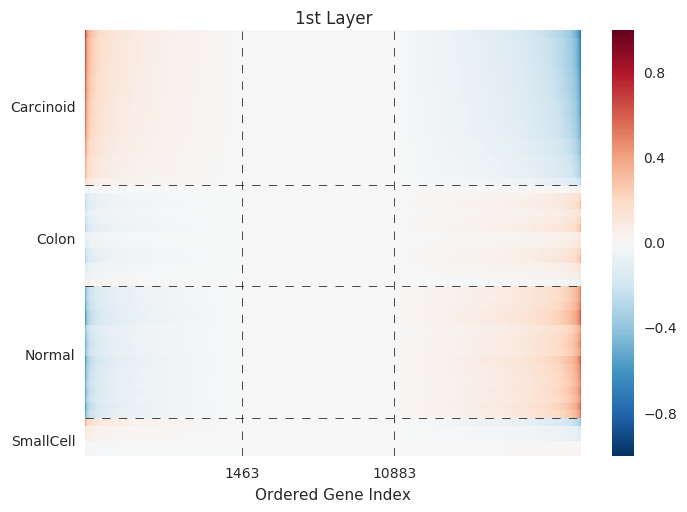

In [8]:
image1 = sns.heatmap(layer_reduced1, vmin=-1, vmax=1, 
                     xticklabels=False, yticklabels=False)
image1.set(xlabel = "Ordered Gene Index", ylabel = "") 
plt.plot(list(image1.get_xlim()), [5,5], 'k--', linewidth = 0.5)
plt.plot(list(image1.get_xlim()), [22,22], 'k--', linewidth = 0.5)
plt.plot(list(image1.get_xlim()), [35,35], 'k--', linewidth = 0.5)
plt.plot([1462, 1462], list(image1.get_ylim()), 'k--', linewidth = 0.5)
plt.plot([10882-8000, 10882-8000], list(image1.get_ylim()), 'k--', linewidth = 0.5)
plt.yticks([2,13,28,45], ["SmallCell", "Normal", "Colon", "Carcinoid"])
plt.xticks([1462, 10882-8000], ["1463", "10883"])
plt.title("1st Layer")
pass
plt.savefig('1stlayer.jpg')

In [9]:
res2 = ssvd(X - layer1)
# second layer
layer2 = res2[2] * res2[0][:, None] * res2[1][None, :]

# divide all entries by the maximum entry
layer_scaled2 = layer2 / np.max(layer2)
# sort column of layer based on v
col_idx = np.argsort(res2[1])
layer_sorted2 = layer_scaled2[:, col_idx]

# rearrange subjects according to u within each subject group
row_idx1 = np.argsort(res2[0][:20])
row_idx2 = np.argsort(res2[0][21:34])+20
row_idx3 = np.argsort(res2[0][34:51])+33
row_idx4 = np.argsort(res2[0][51:])+51
row_idx = np.append(np.append(row_idx1, row_idx2), np.append(row_idx3, row_idx4))
layer_sorted2 = layer_sorted2[row_idx,:]

# 8000 genes that have zero approximation are excluded
layer_reduced2 = np.hstack([layer_sorted2[:,:1488], layer_sorted2[:,1488+8000:]])

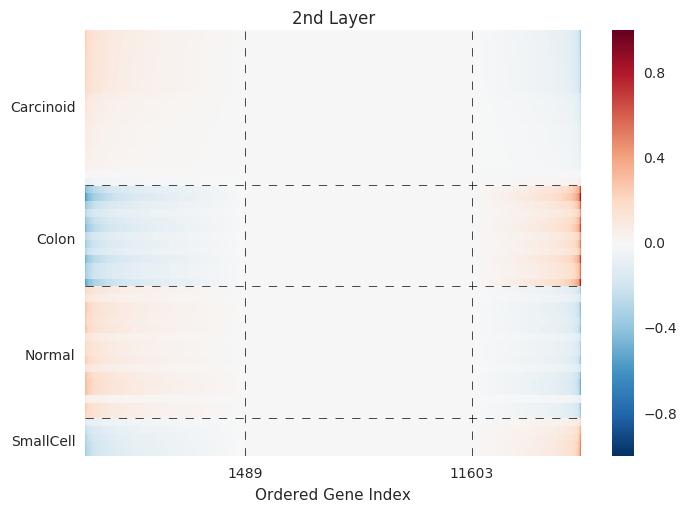

In [10]:
image2 = sns.heatmap(layer_reduced2, vmin=-1, vmax=1, 
                     xticklabels=False, yticklabels=False)
                    
image2.set(xlabel = "Ordered Gene Index", ylabel = "")
plt.plot(list(image2.get_xlim()), [5,5], 'k--', linewidth = 0.5)
plt.plot(list(image2.get_xlim()), [22,22], 'k--', linewidth = 0.5)
plt.plot(list(image2.get_xlim()), [35,35], 'k--', linewidth = 0.5)
plt.plot([1488, 1488], list(image2.get_ylim()), 'k--', linewidth = 0.5)
plt.plot([11603-8000, 11603-8000], list(image2.get_ylim()), 'k--', linewidth = 0.5)
plt.yticks([2,13,28,45], ["SmallCell", "Normal", "Colon", "Carcinoid"])
plt.xticks([1488, 11603-8000], ["1489", "11603"])
plt.title("2nd Layer")
pass
plt.savefig('2ndlayer.jpg')

In [11]:
res3 = ssvd(X - layer1 - layer2,  merr = 10**(-2))
# third layer
layer3 = res3[2] * res3[0][:, None] * res3[1][None, :]

# divide all entries by the maximum entry
layer_scaled3 = layer3 / np.max(layer3)
# sort column of layer based on v
col_idx = np.argsort(res3[1])
layer_sorted3 = layer_scaled3[:, col_idx]

# rearrange subjects according to u within each subject group
row_idx1 = np.argsort(res3[0][:20])
row_idx2 = np.argsort(res3[0][21:34])+20
row_idx3 = np.argsort(res3[0][34:51])+33
row_idx4 = np.argsort(res3[0][51:])+51
row_idx = np.append(np.append(row_idx1, row_idx2), np.append(row_idx3, row_idx4))
layer_sorted3 = layer_sorted3[row_idx,:]

# 8000 genes that have zero approximation are excluded
layer_reduced3 = np.hstack([layer_sorted2[:,:694], layer_sorted2[:,694+8000:]])

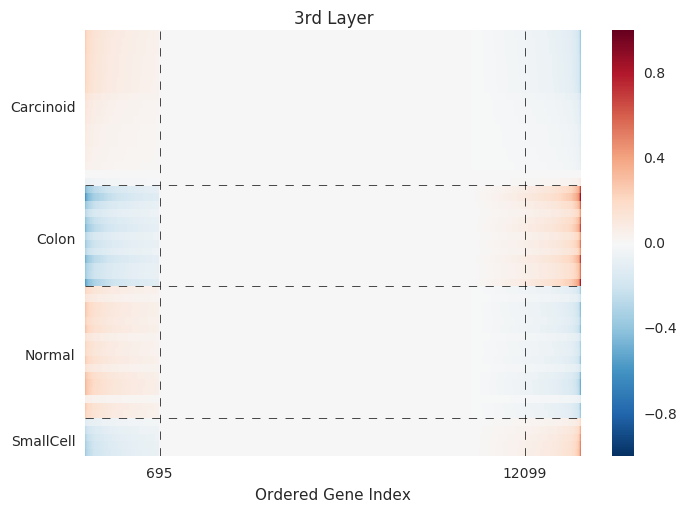

In [12]:
image3 = sns.heatmap(layer_reduced3, vmin=-1, vmax=1, xticklabels=False, yticklabels=False)
image3.set(xlabel = "Ordered Gene Index", ylabel = "")
plt.plot(list(image3.get_xlim()), [5,5], 'k--', linewidth = 0.5)
plt.plot(list(image3.get_xlim()), [22,22], 'k--', linewidth = 0.5)
plt.plot(list(image3.get_xlim()), [35,35], 'k--', linewidth = 0.5)
plt.plot([694, 694], list(image3.get_ylim()), 'k--', linewidth = 0.5)
plt.plot([12098-8000, 12098-8000], list(image3.get_ylim()), 'k--', linewidth = 0.5)
plt.yticks([2,13,28,45], ["SmallCell", "Normal", "Colon", "Carcinoid"])
plt.xticks([694, 12098-8000], ["695", "12099"])
plt.title("3rd Layer")
pass
plt.savefig('3rdlayer.jpg')

## Scatterplots
Scatterplots of the entries of the first three left sparse vectors $\hat{\mathbf{u}}_k (k = 1, 2, 3)$. 

In [13]:
rownames = np.repeat(["Carcinoid", "Colon", "Normal", "SmallCell"], 
                     [20, 13, 17, 6])
us = {"u1": res1[0], "u2": res2[0], "u3": res3[0], "type":rownames}
df_u = pd.DataFrame(us)

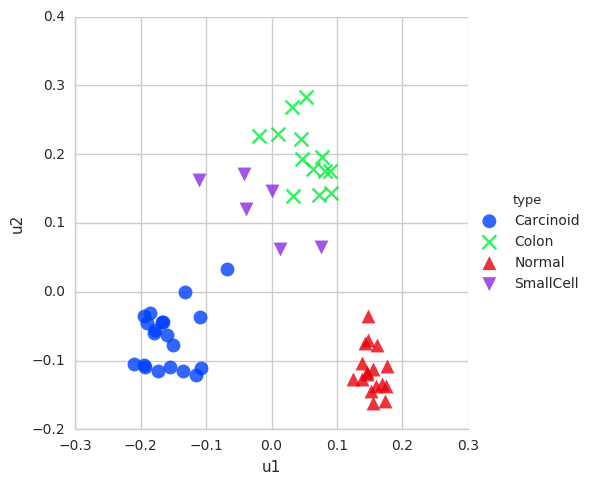

In [14]:
sns.set_style(style = "whitegrid")
sns.lmplot(x="u1", y="u2", hue="type", data=df_u, 
           fit_reg=False, markers=["o", "x", "^", "v"],
          scatter_kws={"s": 100}, palette="bright")
pass
plt.savefig('u12.jpg')

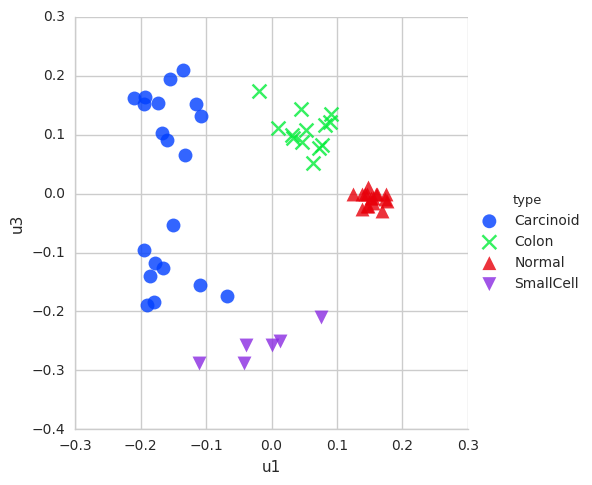

In [15]:
sns.set_style(style = "whitegrid")
sns.lmplot(x="u1", y="u3", hue="type", data=df_u, 
           fit_reg=False, markers=["o", "x", "^", "v"],
          scatter_kws={"s": 100}, palette="bright")
pass
plt.savefig('u13.jpg')

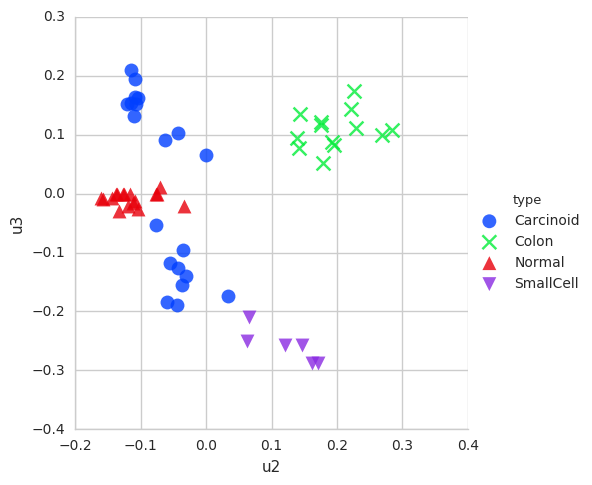

In [16]:
sns.set_style(style = "whitegrid")
sns.lmplot(x="u2", y="u3", hue="type", data=df_u, 
           fit_reg=False, markers=["o", "x", "^", "v"],
          scatter_kws={"s": 100}, palette="bright")
pass
plt.savefig('u23.jpg')